# ANOVA and Linear Regression

This notebook is meant to provide intuition behind how ANOVA and Linear Regression are the same model. 

First we need to import a few libraries and setup some data. Our fake data here is meant to show how fast in hours a drug relieves symptoms. We want to see if there is a difference between a control (placebo), regular, and extra strength version of the medications.

Before looking at this notebook, this StackOverflow question is a good place to get a nice idea of what ANOVA is doing http://stats.stackexchange.com/questions/5278/how-to-visualize-what-anova-does/5280#5280 as well as this blog post http://rpsychologist.com/d3-one-way-anova.

In [45]:
from pandas import DataFrame
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
%matplotlib inline
data_stacked = {
'hour': [ 22, 13.5, 21.5, 20.5, 19, 23, 33, 32.5, 24, 29, 27, 27, 22, 25, 24, 27.5, 25, 28],
'treatment': ['control', 
              'control', 
              'control', 
              'control', 
              'control', 
              'control', 
              'regular', 
              'regular', 
              'regular', 
              'regular', 
              'regular', 
              'regular', 
              'extra', 
              'extra', 
              'extra', 
              'extra', 
              'extra', 
              'extra']
}

Next we use statsmodels to run an ANOVA on our data and view the results.

In [46]:
df = DataFrame(data_stacked)
model = ols('hour ~ C(treatment)', data=df)
anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),2,237.444444,118.722222,12.327661,0.000681
Residual,15,144.458333,9.630556,NaN,NaN


We can see here that our ANOVA has a relatively large F-Value indicating that one or more of the group means differ from one another. We can visualize this by take a look at the three different groups side-by-side. Visualization inspired from https://github.com/thomas-haslwanter/statsintro_python/blob/master/ipynb/8_anovaOneway.ipynb, which is also a great resource for statistics in Python.

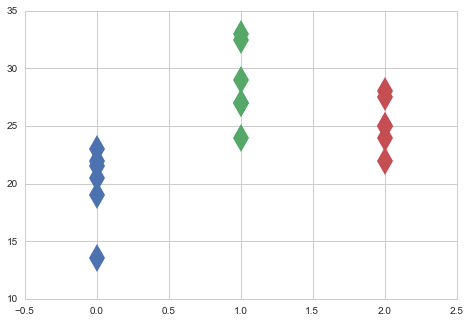

In [69]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.plot([0]*6, data_stacked["hour"][0:6], 'd', ms=20)
axes.plot([1]*6, data_stacked["hour"][6:12], 'd', ms=20)
axes.plot([2]*6, data_stacked["hour"][12:18], 'd', ms=20)
axes.set_xbound([-0.5,2.5])

Visually, it looks the groups may have different means (or at least some of them differ). The results of the ANOVA back up this intuition. The numerator of the F-statistic is the variance between groups, and the denominator is the variance within groups. Intuitively, the larger F-statistic means that the variance between groups overshadows the variance within groups which indicates that the means of one or more of the groups likely differ. See here for more https://en.wikipedia.org/wiki/F-test#Multiple-comparison_ANOVA_problems

So what does this have to do with a linear regression? It turns out they are really the same thing but it requires that we re-code our variables using "dummy-coding" before running the regression. This means we create a new variable for each feature or group. The variable is equal to 1 when the depedendent variable (here, hours to relief) is from that group, and 0 when it is not. You only N - 1 dummy variables to represent N groups, because when the N - 1 variables are set to 0 it indicates that the dependent variable (hour) is from the left-out "reference" group. We will use the get_dummies function from the Pandas library below to create these new variables for us. After that, we will run a regression and confirm our resulting F-Value is the same as the ANOVA.

In [70]:
dummies = pd.get_dummies(df.treatment, prefix='trt').iloc[:,1:]
full_model = ols("hour ~ trt_regular + trt_extra", data = pd.concat([df, dummies], axis=1))
print("F-value: %f" % full_model.fit().fvalue)
full_model.fit().params

F-value: 12.327661


Intercept      19.916667
trt_regular     8.833333
trt_extra       5.333333
dtype: float64

The F-Value is the same. Now in the context of a regression, the F-value compares our current model to the "reduced" model which only contains the intercept (http://blog.minitab.com/blog/adventures-in-statistics/what-is-the-f-test-of-overall-significance-in-regression-analysis
). We can think of this as answering the question: "Does the increased complexity of our current model deliver significantly better results than a much simpler model?" A larger F-value indicates that it does. But what does this have to do with the F-Value from ANOVA. 

Let's start by taking away the "extra strength" level of our factor and just looking at a graph of our "dummy variables" for "control" and "regular strength".

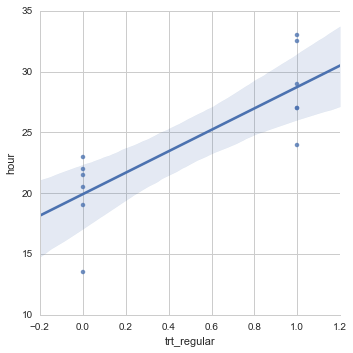

In [48]:
df2 = pd.concat([df, dummies], axis=1)
fig = sns.lmplot(x='trt_regular', y='hour', data=df2.iloc[0:12,:])

Here we only have one dummy variable (because we are looking at only two levels of our factor). The points above 0 (when the dummy variable for "regular strength" is 0) correspond to the control group, and the points above 1 correspond to the "regular strength" group. We have also have the corresponding regression line. As discussed above, our F-test is going to tell us whether this model, with effectively 1 feature, is significantly better than a straight horizontal line (intercept only). Intuitively it looks like the answer here would be yes. 

Below we run the regression and look at the results as well as the same two-level regression as ANOVA.

In [49]:
model = ols("hour ~ trt_regular", data = df2.iloc[0:12,:])
print("F-value: %f" % model.fit().fvalue)
model.fit().params

F-value: 19.574913


Intercept      19.916667
trt_regular     8.833333
dtype: float64

In [50]:
model = ols('hour~ C(treatment)', data=df2.iloc[0:12,:])
anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),1,234.083333,234.083333,19.574913,0.001285
Residual,10,119.583333,11.958333,NaN,NaN


Again, as promised, the F-Values are the same.  We can also take a look in the regression coefficients to see what they are telling us about the dataset. The intercept is the mean of the control group.

In [56]:
np.mean(data['Control']) # This is the intercept

19.916666666666668

and the coefficient for the dummy variable plus the intercept is the mean of the "regular" treatment group.

In [52]:
np.mean(data['regular']) # This is intercept + Coefficient

28.75

You can read more about this here: # http://www.theanalysisfactor.com/why-anova-and-linear-regression-are-the-same-analysis/

So let's look back at the regression with both dummy-coded variables from above and extract formula for the corresponding regression equation (a plane in this case). 

In [58]:
full_model.fit().params

Intercept      19.916667
trt_regular     8.833333
trt_extra       5.333333
dtype: float64

If we graph the dummy-coded groups (now in 3 dimensions) and show the plane, we can see that the F-test in this regression compares the two planes in the image, the one with the two dummy-encoded variables, and one contains only the intercept.

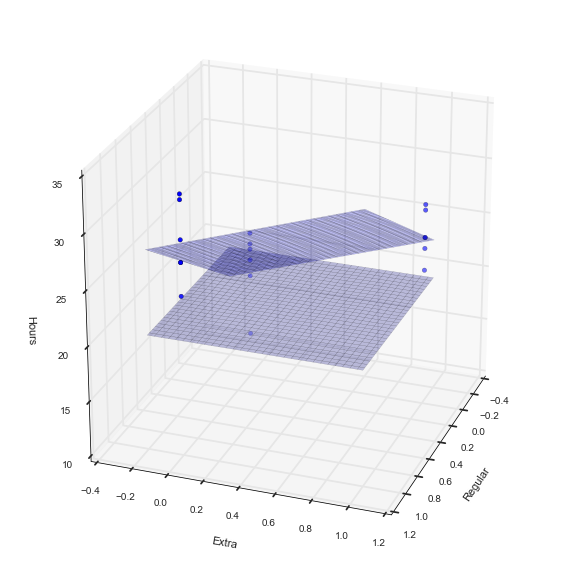

In [55]:
way = df2.iloc[0:18]
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(xs=way['trt_regular'], ys=way['trt_extra'], zs=way['hour'])
ax.set_ylabel('Extra')
ax.set_zlabel('Hours')
ax.set_xlabel('Regular')
ax.set_ybound(0, 1.1)
ax.set_xbound(0, 1.1)
ax.view_init(25, 20)
x_surf=np.arange(-0.2, 1, 0.01)
y_surf=np.arange(-0.2, 1, 0.01)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
z_surf = 19.9167 + 8.8333*x_surf + 5.3333 * y_surf # from the regression above
ax.plot_surface(x_surf, y_surf, z_surf, rstride=4, cstride=4, alpha=0.25)
ax.plot_surface(x_surf, y_surf, 19.9167,  rstride=4, cstride=4, alpha=0.25)

It may not be completely obvious, but you can imagine that the plane using the two dummy-coded variables (on top) does a better job describing the 3 groups of dummy-coded variables in 3 dimensions than the plane that is described only by the intercept (below).

Other Links

http://www.unt.edu/rss/class/Jon/MiscDocs/Cohen_1968.pdf


https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb